# Searching for digit manifolds

In this notebook, we'll calculate the level of agreement between elements of a class of digits. The intention is to use the similarity of class elements to sort the elements into a manifold (each successive element appears to be a slight perturbation or continuous deformation of the previous element).

There are 10 classes of digits 0-9. Let $A$ and $B$ be elements of class $N$. For current purposes, the level of agreement between $A$ and $B$ is given by

$$
    \frac{||A\odot B||}{\sqrt{||A\odot A||}\sqrt{||B\odot B||}},
$$
where $\odot$ represents the element-wise Hadamard product.

I've tried norms of various orders in the above expression for agreement. The norm in both the numerator and denominator should be the same order, since this will give perfect agreement (1.0) for $A = B$. I also tried using the convolution instead of the Hadamard product to allow for translations of $A$ when comparing to $B$. However, the convolution resulted in high agreement between all elements of the sample.

The first few cells of the notebook are just data management and sorting. 

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import morphology as morph
from scipy.signal import fftconvolve, correlate
import numpy.linalg as LA
from sklearn.datasets import fetch_openml

In [2]:
# Load MNIST data from https://www.openml.org/d/554
images, labels = fetch_openml('mnist_784', version=1, return_X_y=True)

In [3]:
''' Right now the images and labels are in separate arrays. 
    I'll put them into a single pandas DataFrame to make it
    easier to sort by label.
'''

images = pd.DataFrame(zip(images,labels), columns = ['Image','Class label'])

# Not really necessary, but I'll sort the images by class label.
images.sort_values(by = 'Class label', inplace = True)

# By default, the 'Class label' column is not integer, so we'll convert it here.
images['Class label'] = images['Class label'].apply(int)

# The images are also flattened, so we'll reshape them to (28,28)
images['Image'] = images['Image'].apply(lambda x: x.reshape((28,28)))

In [4]:
def extract_image(frame, digit):
    """ This function takes in a dataset containing images. 
        The set is converted to a DataFrame, and the images
        corresponding to the given digit are extracted.
        
        An array containing images of the given digit is
        returned.
    """
        
    ims = frame[frame['Class label'] == digit]
    
    # Now ims only contains labels matching the digit, so we can drop the label column.
    ims.drop('Class label', axis = 1, inplace = True)
    
    return np.array(ims['Image'])

def display_lengths(data):
    """ Display the total length of each subset of digits. 
    
        Used for checking that the conversion worked as expected.
    """
    
    for i in range(10):
        print('{} examples of digit {}'.format(len(data[i]), i))
    print('{} examples in total\n'.format(sum(len(data[i]) for i in range(10))))
    return None

In [5]:
data = [extract_image(images, i) for i in range(10)]
display_lengths(data)

6903 examples of digit 0
7877 examples of digit 1
6990 examples of digit 2
7141 examples of digit 3
6824 examples of digit 4
6313 examples of digit 5
6876 examples of digit 6
7293 examples of digit 7
6825 examples of digit 8
6958 examples of digit 9
70000 examples in total



C:\Users\Matt\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
# Finally, save each digit separately

zero = data[0]
one = data[1]
two = data[2]
three = data[3]
four = data[4]
five = data[5]
six = data[6]
seven = data[7]
eight = data[8]
nine = data[9]

# Calculating the agreement between classes

We'll take samples from a class and calculate the sample variance. Next, we calculate the agreement within the sample.

In [7]:
# Take N samples from each digit

N = 500

sample0 = zero[:N]
sample1 = one[:N]
sample2 = two[:N]
sample3 = three[:N]
sample4 = four[:N]
sample5 = five[:N]
sample6 = six[:N]
sample7 = seven[:N]
sample8 = eight[:N]
sample9 = nine[:N]

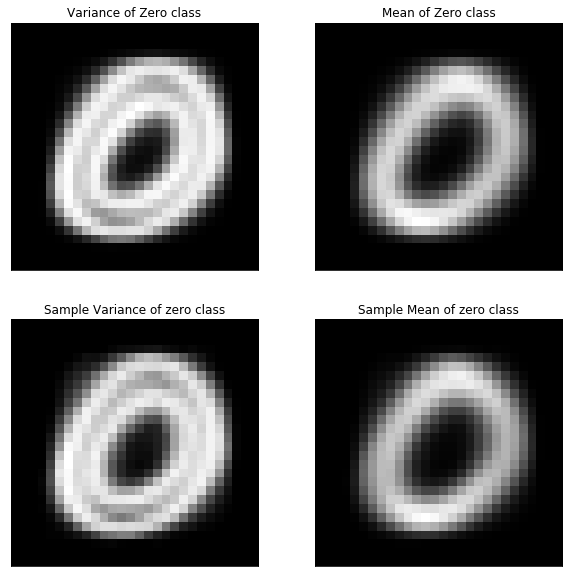

In [8]:
# Variance of the zero digits

fig, ax = plt.subplots(2,2,figsize=(10,10))
ax

ax[0,0].imshow(zero.var(), cmap = 'gray')
ax[0,0].set(title = 'Variance of Zero class', xticks = [], yticks = []);

ax[0,1].imshow(zero.mean(), cmap = 'gray')
ax[0,1].set(title = 'Mean of Zero class', xticks = [], yticks = []);

ax[1,0].imshow(sample0.var(), cmap = 'gray')
ax[1,0].set(title = 'Sample Variance of zero class', xticks = [], yticks = []);

ax[1,1].imshow(sample0.mean(), cmap = 'gray')
ax[1,1].set(title = 'Sample Mean of zero class', xticks = [], yticks = []);

# plt.imshow(zero.var(), cmap = 'gray');

# Finding the families for the zero digit class

The algorithm below calculates the agreement between all elements in a sample of the zero digits. We then sort the elements into 'families', where the 'siblings' in each family are given by agreement over 80%. 

When each family is identified, we take the mean image of each family.

**Note:** When I programmed this, I was using 'chain' instead of 'family'. We'll take that to mean the same thing for now and I'll change it later.

In [9]:
agree = [LA.norm(A*B,2)/(np.sqrt(LA.norm(A*A,2))*np.sqrt(LA.norm(B*B,2))) for A in sample0 for B in sample0]

In [10]:
agree_chart = pd.DataFrame(np.array(agree).reshape(N,N))
agree_chart[agree_chart > 0.99] = 0
agree_chart

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.000000,0.663513,0.802683,0.556097,0.885863,0.705644,0.605659,0.669312,0.507076,0.705133,...,0.752484,0.763214,0.652833,0.670384,0.634345,0.823615,0.743892,0.709118,0.712960,0.779319
1,0.663513,0.000000,0.807227,0.777356,0.792173,0.817978,0.672528,0.850875,0.824166,0.872441,...,0.764119,0.814566,0.499906,0.798160,0.919178,0.836403,0.820647,0.810631,0.800454,0.875451
2,0.802683,0.807227,0.000000,0.712134,0.904666,0.772518,0.775089,0.796656,0.563646,0.845933,...,0.687820,0.754197,0.620689,0.763288,0.727962,0.776405,0.746536,0.743066,0.712362,0.793156
3,0.556097,0.777356,0.712134,0.000000,0.619667,0.689618,0.808096,0.849970,0.751411,0.841608,...,0.767678,0.738418,0.766548,0.783962,0.711487,0.720234,0.803861,0.789048,0.635250,0.742946
4,0.885863,0.792173,0.904666,0.619667,0.000000,0.779708,0.691269,0.761500,0.594195,0.811141,...,0.702788,0.779475,0.641796,0.716977,0.728046,0.803929,0.763383,0.748200,0.727484,0.804985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.823615,0.836403,0.776405,0.720234,0.803929,0.719685,0.673085,0.828813,0.644073,0.838311,...,0.892930,0.891298,0.607407,0.857454,0.768576,0.000000,0.924406,0.824490,0.884527,0.893741
496,0.743892,0.820647,0.746536,0.803861,0.763383,0.652227,0.680888,0.832091,0.719917,0.824240,...,0.843465,0.922615,0.708354,0.862677,0.776408,0.924406,0.000000,0.781199,0.881031,0.829903
497,0.709118,0.810631,0.743066,0.789048,0.748200,0.792584,0.798074,0.873766,0.599118,0.868942,...,0.918209,0.768267,0.502181,0.787239,0.768366,0.824490,0.781199,0.000000,0.786506,0.859855
498,0.712960,0.800454,0.712362,0.635250,0.727484,0.696693,0.666021,0.746532,0.642696,0.776302,...,0.817745,0.900901,0.742740,0.840721,0.735377,0.884527,0.881031,0.786506,0.000000,0.854394


In [11]:
def get_chains(ag_chart, threshold = 0.8, start_row = 0):
    """ Get the list of chains of digits with high levels of agreement. 
    """
    
    chains = []   
    
    while not ag_chart.empty:
        chain = [start_row]

        ag_chart.drop(start_row, axis = 1, inplace = True)

        while ag_chart.loc[start_row].max() > threshold:
            
            # Find the column that corresponds to the next row to search
            next_row = ag_chart.loc[start_row].idxmax(axis = 0)
            ag_chart.loc[start_row] = 0

            start_row = next_row
            # Drop the column we just searched
            ag_chart.drop(start_row, axis = 1, inplace = True)

            chain.append(start_row)
        
        ag_chart.drop(chain, axis = 0, inplace = True)
        chains.append(chain)
    
        try:
            start_row = ag_chart.index[0]
        except:
            break
            
    return chains

This next cell finds the chains of digits that have agreement of more than 80%.

In [12]:
threshold = 0.8

families = get_chains(agree_chart, threshold = threshold)
print(families)

[[0, 282, 4, 163, 242, 51, 86, 64, 112, 391, 490, 394, 71, 429, 35, 118, 426, 472, 145, 229, 156, 449, 419, 113, 153, 411, 179, 326, 493, 281, 49, 140, 165, 222, 345, 465, 158, 93, 122, 92, 460, 478, 491, 137, 63, 344, 440, 446, 99, 307, 67, 273, 107, 104, 69, 193, 182, 404, 132, 154, 245, 359, 190, 269, 20, 9, 7, 433, 1, 334, 215, 463, 97, 232, 24, 483, 352, 31, 438, 270, 373, 420, 160, 116, 461, 392, 349, 355, 314, 295, 239, 482, 316, 405, 284, 274, 311, 343, 101, 142, 95, 358, 434, 496, 485, 237, 400, 399, 350, 168, 60, 135, 328, 331, 205, 487, 480, 475, 210, 495, 336, 103, 177, 275, 147, 361, 418, 143, 340, 216, 318, 73, 260, 293, 243, 389, 120, 131, 238, 427, 346, 425, 233, 53, 48, 55, 362, 127, 187, 149, 264, 335, 194, 252, 417, 432, 62, 47, 175, 294, 266, 180, 255, 228, 368, 424, 409, 421, 450, 459, 192, 259, 298, 477, 58, 499, 467, 59, 133, 159, 144, 251, 109, 75, 447, 213, 161, 288, 257, 78, 479, 347, 125, 468, 141, 383, 365, 375, 386, 384, 370, 393, 403, 13, 22, 272, 208, 202

In [13]:
def display_chain(chains, sample):
    """ Display the mean digit obtained by averaging over each chain of digits. """
    
    ims = [sum(sample[i] for i in chain)/len(chain) for chain in chains]
    
    print('Algorithm found {} families of digits with threshold {}.'.format(len(chains), threshold))
    
    fig, ax = plt.subplots(1,len(ims),figsize=(12,12))
    
    for i in range(len(ims)):
        ax[i].imshow(ims[i], cmap = 'gray');
        ax[i].set(xticks = [], yticks = []);
    return None

display_chain(families, sample0)

Algorithm found 51 families of digits with threshold 0.8.


In the output above, families with more than one member have their 'family mean' displayed (the mean of all images in the family).

## Finding family means for every digit class

This is working really well for finding chains of similar digits. Now I'll perform the algorithm on each digit class.

In [14]:
samples = [sample0, sample1, sample2, sample3, sample4, sample5, sample6, sample7, sample8, sample9]

In [15]:
def similarity(sample):
    """ Find the similarity matrix for a sample taken from a class of digits. """
    
    agree = [LA.norm(A*B,2)/(np.sqrt(LA.norm(A*A,2))*np.sqrt(LA.norm(B*B,2))) for A in sample for B in sample]
    
    agree_chart = pd.DataFrame(np.array(agree).reshape(N,N))
    agree_chart[agree_chart > 0.99] = 0
    
    return agree_chart

In [16]:
# Find the agreement chart for all samples.
agreement_charts = [similarity(sample) for sample in samples]

In [17]:
# Find the chains of similar digits for all digit classes.

all_families = {key:get_chains(ag, threshold = threshold) for key,ag in zip(range(len(agreement_charts)),agreement_charts)}

Algorithm found 51 families of digits with threshold 0.8.
Algorithm found 11 families of digits with threshold 0.8.
Algorithm found 82 families of digits with threshold 0.8.
Algorithm found 69 families of digits with threshold 0.8.
Algorithm found 45 families of digits with threshold 0.8.
Algorithm found 95 families of digits with threshold 0.8.
Algorithm found 58 families of digits with threshold 0.8.
Algorithm found 46 families of digits with threshold 0.8.
Algorithm found 101 families of digits with threshold 0.8.
Algorithm found 39 families of digits with threshold 0.8.


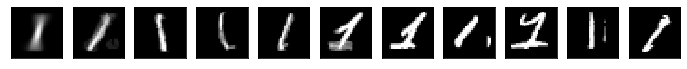

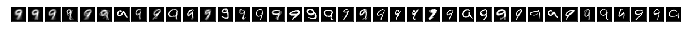

In [18]:
for key, sample in zip(all_families, samples):
    display_chain(all_families[key], sample)

# Computing projections onto the bases

- take some random examples of digits, calculate the agreement with each basis; take largest value as the class

Further ideas:
- reduce the basis size

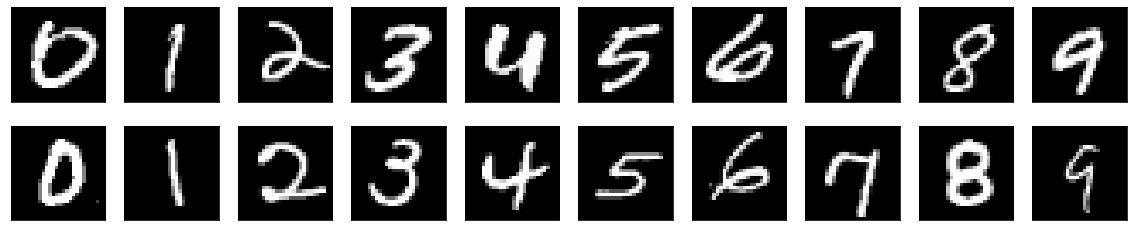

In [43]:
# Selecting test digits, 2 from each class

testing = [np.random.choice(data[i][500:], 2, replace=False) for i in range(10)]

# Show the test digits
fig, ax = plt.subplots(2, 10, figsize = (20,4))

for i in range(20):
    if i < 10:
        ax[0,i].imshow(testing[i][0], cmap = 'gray')
        ax[0,i].set(xticks = [], yticks = []);
    
    if i >= 10:
        ax[1,i-10].imshow(testing[i-10][1], cmap = 'gray');
        ax[1,i-10].set(xticks = [], yticks = []);

Now I'll create testing sets and find the level of agreement between each testing digit and the digits chains for all classes.

In [21]:
N = 100

test_sets = [np.random.choice(digit, size = N, replace = False) for digit in [zero,one,two,three,four,five,six,seven,eight,nine]]

In [22]:
def cross_similarity(sample1, sample2):
    """ Calculate the similarity matrix between two samples. """
    
    agree = [LA.norm(A*B,2)/(np.sqrt(LA.norm(A*A,2))*np.sqrt(LA.norm(B*B,2))) for A in sample1 for B in sample2]
    
    agree_chart = pd.DataFrame(np.array(agree).reshape(len(sample1),len(sample2)))
    agree_chart[agree_chart > 0.99] = 0
    
    return agree_chart

# This only computes agreement with the chains from the zero class
agree_zero = [cross_similarity(sample0[chain], test) for chain in all_families[0] for test in test_sets]

In [23]:
# There are 22 chains from the zero class and 100 test sets.
len(agree_zero)

220

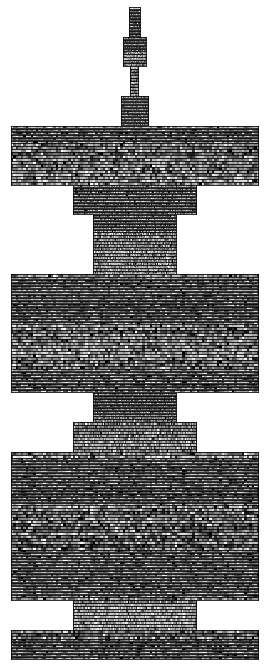

In [24]:
fig, ax = plt.subplots(len(agree_zero),1,figsize=(12,12))

for i in range(len(agree_zero)):
    ax[i].imshow(agree_zero[i], cmap = 'gray');
    ax[i].set(xticks = [], yticks = []);

In [ ]:
def project(digit, family):
    """ Get the coefficients of a digit in terms of its digit family. """
    
    
    
    return 

I need a better way to represent this collection of agreement charts.